In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [25]:
# Load dataset
data = pd.read_csv('TCS_1h.csv')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16464 entries, 0 to 16463
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    16464 non-null  object 
 1   open    16464 non-null  float64
 2   high    16464 non-null  float64
 3   low     16464 non-null  float64
 4   close   16464 non-null  float64
 5   volume  16464 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 771.9+ KB


In [27]:
data.describe

<bound method NDFrame.describe of                             date     open     high      low    close  volume
0      2015-02-02 09:15:00+05:30  1241.00  1255.00  1231.03  1252.58  688640
1      2015-02-02 10:15:00+05:30  1252.98  1252.98  1248.50  1251.08  362390
2      2015-02-02 11:15:00+05:30  1251.08  1257.10  1245.98  1247.00  372066
3      2015-02-02 12:15:00+05:30  1247.00  1252.50  1247.00  1249.63  429868
4      2015-02-02 13:15:00+05:30  1249.65  1255.65  1248.88  1251.03  475188
...                          ...      ...      ...      ...      ...     ...
16459  2024-08-14 11:15:00+05:30  4290.50  4297.40  4280.15  4281.65  206030
16460  2024-08-14 12:15:00+05:30  4281.65  4304.20  4278.10  4285.00  347344
16461  2024-08-14 13:15:00+05:30  4285.00  4287.55  4270.05  4281.65  207409
16462  2024-08-14 14:15:00+05:30  4281.65  4295.75  4274.35  4290.45  552017
16463  2024-08-14 15:15:00+05:30  4290.40  4306.20  4288.65  4293.00  405125

[16464 rows x 6 columns]>

**Implement the Strategy and Generate Signals:**

In [28]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [29]:
# Trend-Following Strategy: Moving Average Crossover
def trend_following_strategy(data, short_window=50, long_window=200):
    data['short_mavg'] = data['close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['close'].rolling(window=long_window).mean()
    data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1, 0)
    data['position'] = data['signal'].diff()  # Change in signal to identify trades
    return data

In [30]:
# 2. Mean-Reversion Strategy: Bollinger Bands
def mean_reversion_strategy(data, window=20):
    data['ma'] = data['close'].rolling(window=window).mean()
    data['std'] = data['close'].rolling(window=window).std()
    data['upper_band'] = data['ma'] + (2 * data['std'])
    data['lower_band'] = data['ma'] - (2 * data['std'])
    data['signal'] = 0
    data['signal'] = np.where(data['close'] < data['lower_band'], 1, data['signal'])
    data['signal'] = np.where(data['close'] > data['upper_band'], -1, data['signal'])
    data['position'] = data['signal'].diff()
    return data

In [31]:
# 3. Momentum Strategy: RSI
def calculate_RSI(data, window=14):
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['rsi'] = rsi
    return data


In [32]:
def momentum_strategy(data, rsi_period=14, overbought=70, oversold=30):
    data = calculate_RSI(data, window=rsi_period)
    data['signal'] = 0
    data['signal'] = np.where(data['rsi'] < oversold, 1, data['signal'])
    data['signal'] = np.where(data['rsi'] > overbought, -1, data['signal'])
    data['position'] = data['signal'].diff()
    return data


**Basic Backtesting Logic (Returns based on signals):**

In [33]:
# Backtesting function
def backtest_strategy(data, strategy_name, transaction_cost=0.001):
    data['returns'] = data['close'].pct_change()
    data['strategy_returns'] = data['returns'] * data['signal'].shift(1) - transaction_cost * abs(data['position'])
    data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod() - 1
    return data[['close', 'signal', 'position', 'strategy_returns', 'cumulative_returns']]



 **Apply all strategies**

In [34]:

trend_data = backtest_strategy(trend_following_strategy(data.copy()), "Trend-Following")
mean_reversion_data = backtest_strategy(mean_reversion_strategy(data.copy()), "Mean-Reversion")
momentum_data = backtest_strategy(momentum_strategy(data.copy()), "Momentum")

**Portfolio Analysis:**

In [35]:
# Portfolio Analysis: Combine strategies
portfolio_data = pd.DataFrame(index=data.index)
portfolio_data['trend_returns'] = trend_data['strategy_returns']
portfolio_data['mean_reversion_returns'] = mean_reversion_data['strategy_returns']
portfolio_data['momentum_returns'] = momentum_data['strategy_returns']
portfolio_data['portfolio_returns'] = portfolio_data.mean(axis=1)
portfolio_data['cumulative_portfolio_returns'] = (1 + portfolio_data['portfolio_returns']).cumprod() - 1


**Plotting the results**

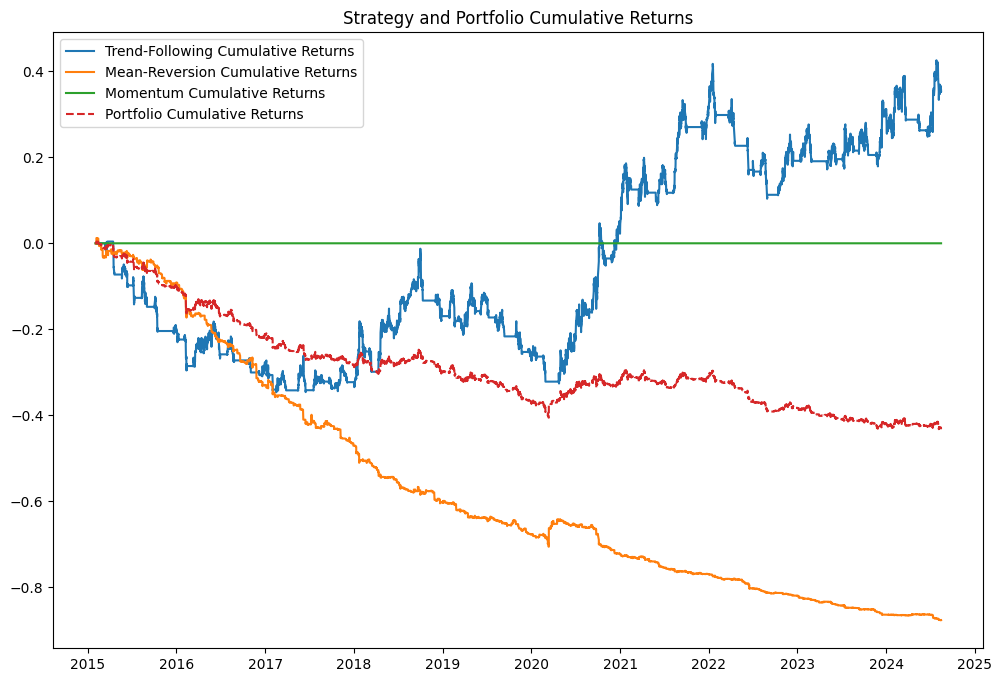

In [36]:

plt.figure(figsize=(12, 8))
plt.plot(trend_data['cumulative_returns'], label='Trend-Following Cumulative Returns')
plt.plot(mean_reversion_data['cumulative_returns'], label='Mean-Reversion Cumulative Returns')
plt.plot(momentum_data['cumulative_returns'], label='Momentum Cumulative Returns')
plt.plot(portfolio_data['cumulative_portfolio_returns'], label='Portfolio Cumulative Returns', linestyle='--')
plt.legend()
plt.title('Strategy and Portfolio Cumulative Returns')
plt.show()

# Correlation Analysis

In [37]:

correlation_matrix = portfolio_data[['trend_returns', 'mean_reversion_returns', 'momentum_returns']].corr()
print("Correlation Matrix between Strategies:\n", correlation_matrix)


Correlation Matrix between Strategies:
                         trend_returns  mean_reversion_returns  \
trend_returns                1.000000               -0.029224   
mean_reversion_returns      -0.029224                1.000000   
momentum_returns                  NaN                     NaN   

                        momentum_returns  
trend_returns                        NaN  
mean_reversion_returns               NaN  
momentum_returns                     NaN  


In [38]:
# Display final cumulative returns for each strategy and the portfolio
print("Final Cumulative Returns:\n")
print("Trend-Following Strategy:", trend_data['cumulative_returns'].iloc[-1])
print("Mean-Reversion Strategy:", mean_reversion_data['cumulative_returns'].iloc[-1])
print("Momentum Strategy:", momentum_data['cumulative_returns'].iloc[-1])
print("Portfolio:", portfolio_data['cumulative_portfolio_returns'].iloc[-1])

Final Cumulative Returns:

Trend-Following Strategy: 0.3555764573817841
Mean-Reversion Strategy: -0.8771433987400535
Momentum Strategy: 0.0
Portfolio: -0.43021278197473367


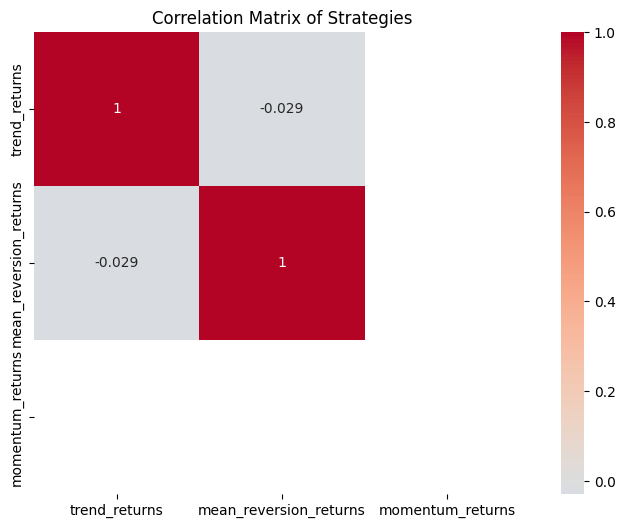

In [39]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Strategies")
plt.show()

In [41]:
def generate_trade_log(data, signals, strategy_name):
    trade_log = []
    position = 0
    entry_price = 0
    entry_date = None
    
    for i in range(1, len(data)):
        # Detect entry signal
        if signals.iloc[i] != position and signals.iloc[i] != 0:
            # If exiting a position, record the trade
            if position != 0:
                exit_price = data['Close'].iloc[i]
                exit_date = data.index[i]
                direction = 'Long' if position == 1 else 'Short'
                pnl = (exit_price - entry_price) * position if position == 1 else (entry_price - exit_price)
                
                trade_log.append({
                    'Strategy': strategy_name,
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Direction': direction,
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'P&L': pnl
                })
                
            # Update the entry details for the new position
            entry_price = data['Close'].iloc[i]
            entry_date = data.index[i]
            position = signals.iloc[i]

        # Check for position exit (i.e., Signal goes to 0)
        elif signals.iloc[i] == 0 and position != 0:
            exit_price = data['Close'].iloc[i]
            exit_date = data.index[i]
            direction = 'Long' if position == 1 else 'Short'
            pnl = (exit_price - entry_price) * position if position == 1 else (entry_price - exit_price)
            
            trade_log.append({
                'Strategy': strategy_name,
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Direction': direction,
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'P&L': pnl
            })
            
            position = 0  # Reset position to no position

    # Convert to DataFrame
    trade_log_df = pd.DataFrame(trade_log)
    return trade_log_df
   
    # Generate Signals
tf_signals = tf_strategy.generate_signals()
mr_signals = mr_strategy.generate_signals()
mom_signals = mom_strategy.generate_signals()

# Example usage
tf_trade_log = generate_trade_log(data, tf_signals, "Trend Following")
mr_trade_log = generate_trade_log(data, mr_signals, "Mean Reversion")
mom_trade_log = generate_trade_log(data, mom_signals, "Momentum")

# Combine all trade logs
all_trade_logs = pd.concat([tf_trade_log, mr_trade_log, mom_trade_log], ignore_index=True)

# Display trade logs
print(all_trade_logs)


NameError: name 'tf_strategy' is not defined